In [4]:
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

import utils
from train import conf
import glob
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

import MI
import tqdm
import bvcopula
from vine import CVine

In [5]:
animal = 'ST260'
day_name = 'Day1'
exp_pref = f'{animal}_{day_name}'
exp_postfix = 'gnT'
path_models = f"{conf.path2outputs}/{exp_pref}_{exp_postfix}"
path_models

'/home/nina/outputs/ST260_Day1_gnT'

In [48]:
list_files = glob.glob(f"{path_models}/models_*.pkl")

In [49]:
with open(f"{path_models}/models_layer0.pkl","rb") as f:
    results = pkl.load(f)
NN = len(results)+1
WAICs = np.zeros((NN,NN))
WAICs[0,1:] = [a[3] for a in results]
for layer in range(1,len(results)):
    with open(f"{path_models}/models_layer{layer}.pkl","rb") as f:
        res = pkl.load(f)
    WAICs[layer,(layer+1):] = [a[3] for a in res]

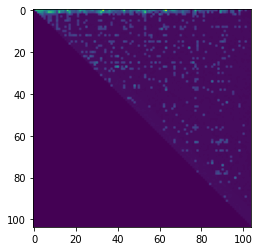

In [50]:
plt.imshow(WAICs[:])

In [18]:
device = "cuda:0"

# create linspace
N_points = 50
train_x = torch.linspace(0,1,N_points).to(device)

#real
X,Y = utils.standard_loader(f"{conf.path2data}/{exp_pref}_standard.pkl")
# N_points=X.shape[0]
# N_points = 200
# train_x = torch.tensor(X, device=device).float()
# train_x = train_x[torch.randperm(train_x.numel())[:N_points]]

copula_layers, likelihood_layers, fs_layers = [], [], []
for layer in tqdm.tqdm(range(0,NN-1)):
    copulas, liks, fs = [], [], []
    with open(f"{path_models}/models_layer{layer}.pkl","rb") as f:
        results = pkl.load(f)
    out_dir = f'{path_models}/layer{layer}'
    for n,res in enumerate(results):
        if res[1]!='Independence':
            likelihoods = res[0]
            weights_file = f"{out_dir}/model_{exp_pref}_{exp_postfix}_{layer}-{layer+n+1}.pth"
            model = utils.get_model(weights_file, likelihoods, device)
            liks.append(model.likelihood)
            with torch.no_grad():
                f = model(train_x).mean
                copula = model.likelihood.get_copula(f)
                copulas.append(copula)
                fs.append(f)
        else:
            copulas.append(bvcopula.MixtureCopula(torch.empty(1,0,device=device),
                    torch.ones(1,N_points,device=device),
                    [bvcopula.IndependenceCopula]))
            fs.append(None)
            liks.append([bvcopula.IndependenceCopula_Likelihood()])
#     else:
#         for n in range(NN-1-layer):
#             copulas.append(bvcopula.MixtureCopula(torch.empty(1,0,device=device),
#                         torch.ones(1,N_points,device=device),
#                         [bvcopula.IndependenceCopula]))
#             fs.append(None)
#             liks.append([bvcopula.IndependenceCopula_Likelihood()])
    copula_layers.append(copulas)
    likelihood_layers.append(liks)
    fs_layers.append(fs)

100%|██████████| 103/103 [00:08<00:00, 12.86it/s]


In [19]:
# [len(copula_layers[i]) for i in range(108)]
c, c1 = 0, 0
for layer in copula_layers:
    for copulas in layer:
        c+= 1
        if len(copulas.copulas)==1:
            if copulas.copulas[0].__name__ == "IndependenceCopula":
                c1 += 1
print(c1,c,c1/c,c-c1)

4661 5356 0.8702389843166543 695


In [20]:
# train_x = torch.ones(1,device=device)
vine = CVine(copula_layers[1:],train_x,device=device)

In [32]:
# with open(f"{home}/results/D1UxFU_vine.pkl","wb") as f:
#     pkl.dump([copula_layers,vine],f)
# -18.64 -18.36 -20.93


# copula_layers0 = copula_layers.copy()
copula_layers = copula_layers0[1:]

In [33]:
h = []
mc_size=5000
sem_tol = 0.1
t_start = time.time()
Ns = 103-np.array([0,10,20,30,40,50,60,70,80,90,100,101,102,103])
# h.append(H[0])
for n in tqdm.tqdm(Ns[:-1]):
    layers = [[copula_layers[i][j] for j in range(n-1-i)] for i in range(n-1)]
    vineR = CVine(layers,train_x,device=device)
    entropy = vineR.entropy(sem_tol=sem_tol, mc_size=mc_size, v=True)
    h.append(entropy.cpu().numpy())
    print(h[-1].mean())
h.append(np.zeros_like(h[-1]))
t_end = time.time()

d = {}
d['Ns'] = Ns
d['inputs'] = train_x.cpu().numpy()
d['H'] = h
d['comment'] = f'The entropies, calculated at "inputs", for a subpopulation of (n from Ns) variables, \
using mc_size={mc_size}, sem_tol={sem_tol} and a model from {path_models}; \
The whole process took {(t_end-t_start)//(60*60)} h {(t_end-t_start)//60%60} min.'

with open(f"{home}/results/HYgX_subpop_D{day_name[-1]}_{exp_postfix}C.pkl","wb") as f:
    pkl.dump(d,f)

  0%|          | 0/13 [00:00<?, ?it/s]

tensor(1.0207, device='cuda:0')


  8%|▊         | 1/13 [01:03<12:41, 63.46s/it]

-16.727345
tensor(1.0157, device='cuda:0')


 15%|█▌        | 2/13 [01:59<11:14, 61.28s/it]

-16.455664
tensor(1.0015, device='cuda:0')


 23%|██▎       | 3/13 [02:46<09:28, 56.88s/it]

-15.434146


 31%|███       | 4/13 [03:20<07:29, 49.99s/it]

tensor(0.9788, device='cuda:0')
-14.3055105


 38%|███▊      | 5/13 [03:44<05:39, 42.40s/it]

-13.44318


 46%|████▌     | 6/13 [04:03<04:07, 35.40s/it]

-12.038158


 54%|█████▍    | 7/13 [04:15<02:48, 28.15s/it]

-10.961065


 62%|██████▏   | 8/13 [04:21<01:48, 21.64s/it]

-9.039144


 69%|██████▉   | 9/13 [04:24<01:04, 16.08s/it]

-7.028787


100%|██████████| 13/13 [04:25<00:00, 20.43s/it]

-4.987465
-0.92672706
-0.49265298
0.0


In [34]:
H = []
mc_size=5000
sem_tol = 0.1
t_start = time.time()
Ns = np.array([0,10,20,30,40,50,60,70,80,90,94,97,100,101,102])
for n in tqdm.tqdm(Ns):
    entropy = vine.truncate(n).entropy(sem_tol=sem_tol, mc_size=mc_size, v=False)
    H.append(entropy.cpu().numpy())
    print(H[-1].mean())
t_end = time.time()

d = {}
d['Ns'] = Ns
d['inputs'] = train_x.cpu().numpy()
d['H'] = H
d['comment'] = f'The entropies, calculated at "inputs", with a truncated model \
such that the last (n from Ns) layers are removed, \
using mc_size={mc_size}, sem_tol={sem_tol} and a model from {path_models}; \
The whole process took {(t_end-t_start)//(60*60)} h {(t_end-t_start)//60%60} min.'
    
with open(f"{home}/results/HYgX_trunc_D{day_name[-1]}_{exp_postfix}C.pkl","wb") as f:
    pkl.dump(d,f)

  7%|▋         | 1/15 [01:03<14:49, 63.56s/it]

-16.719465


 13%|█▎        | 2/15 [02:07<13:46, 63.55s/it]

-16.72322


 20%|██        | 3/15 [03:10<12:41, 63.43s/it]

-16.670898


 27%|██▋       | 4/15 [04:12<11:34, 63.13s/it]

-16.47306


 33%|███▎      | 5/15 [05:13<10:25, 62.50s/it]

-15.988317


 40%|████      | 6/15 [06:13<09:15, 61.69s/it]

-15.7296095


 47%|████▋     | 7/15 [07:12<08:06, 60.79s/it]

-15.495533


 53%|█████▎    | 8/15 [08:08<06:56, 59.47s/it]

-14.9651575


 60%|██████    | 9/15 [08:55<05:34, 55.69s/it]

-13.219619


 67%|██████▋   | 10/15 [09:37<04:17, 51.52s/it]

-11.764104


 73%|███████▎  | 11/15 [10:15<03:10, 47.58s/it]

-10.652838


 80%|████████  | 12/15 [10:52<02:13, 44.41s/it]

-10.112725


 87%|████████▋ | 13/15 [11:27<01:23, 41.56s/it]

-8.937511


 93%|█████████▎| 14/15 [11:57<00:38, 38.02s/it]

-8.123058


100%|██████████| 15/15 [12:00<00:00, 48.00s/it]

0.0


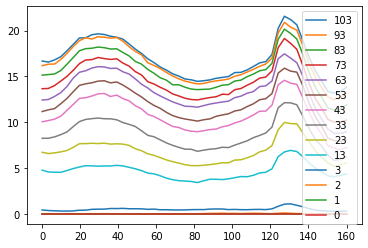

In [24]:
with open(f"{home}/results/HYgX_subpop_D{day_name[-1]}_{exp_postfix}C.pkl","rb") as f:
    data = pkl.load(f)
for i in range(len(data['Ns'])):
    plt.plot(data['inputs']*160,-data['H'][i],label=f"{data['Ns'][i]}")
plt.legend()

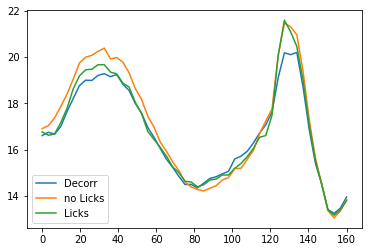

In [51]:
with open(f"{home}/results/HYgX_subpop_D{day_name[-1]}_gLC.pkl","rb") as f:
    data = pkl.load(f)
plt.plot(data['inputs']*160,-data['H'][0],label=f"Decorr")
with open(f"{home}/results/HYgX_subpop_D{day_name[-1]}_gnL.pkl","rb") as f:
    data = pkl.load(f)
plt.plot(data['inputs']*160,-data['H'][0],label=f"no Licks")
with open(f"{home}/results/HYgX_subpop_D{day_name[-1]}_gL.pkl","rb") as f:
    data = pkl.load(f)
plt.plot(data['inputs']*160,-data['H'][0],label=f"Licks")
plt.legend()

In [13]:
len(data['H'])

15

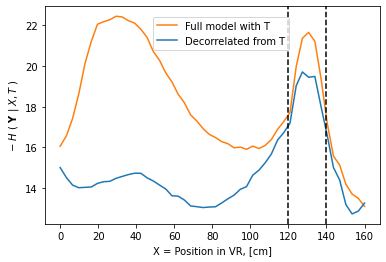

In [34]:
with open(f"{home}/results/HYgX_trunc_D{day_name[-1]}_gT.pkl","rb") as f:
    data = pkl.load(f)
plt.plot(data['inputs']*160,-data['H'][0],label="Full model with T",color='C1')
with open(f"{home}/results/HYgX_trunc_D{day_name[-1]}_gTC.pkl","rb") as f:
    data = pkl.load(f)
plt.plot(data['inputs']*160,-data['H'][0],label="Decorrelated from T",color='C0')
# with open(f"{home}/results/HYgX_subpop_D{day_name[-1]}_gnT.pkl","rb") as f:
#     data = pkl.load(f)
# plt.plot(data['inputs']*160,-data['H'][0],label=f"no time")
# with open(f"{home}/results/HYgX_subpop_D{day_name[-1]}C.pkl","rb") as f:
#     _,inputs,H = pkl.load(f)
# argsort = np.argsort(inputs)
# plt.plot(inputs[argsort]*160,-H[0][argsort],label=f"no time")
plt.xlabel(r"X = Position in VR, [cm]")
plt.ylabel(r"$-~H~(~\mathbf{Y}~|~X,T~)$")
plt.axvline(120,c='k',linestyle='dashed')
plt.axvline(140,c='k',linestyle='dashed')
plt.legend(loc=(0.322,0.8))

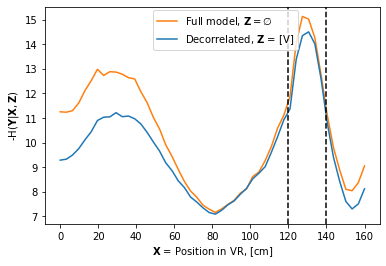

In [18]:
with open(f"{home}/results/HYgX_subpop_D{day_name[-1]}_gV.pkl","rb") as f:
    data = pkl.load(f)
plt.plot(data['inputs']*160,-data['H'][0],label=r"Full model, $\mathbf{Z} = \emptyset$",color='C1')
with open(f"{home}/results/HYgX_subpop_D{day_name[-1]}_gVC.pkl","rb") as f:
    data = pkl.load(f)
plt.plot(data['inputs']*160,-data['H'][0],label=r"Decorrelated, $\mathbf{Z}$ = [V]",color='C0')
# with open(f"{home}/results/HYgX_subpop_D{day_name[-1]}_gnT.pkl","rb") as f:
#     data = pkl.load(f)
# plt.plot(data['inputs']*160,-data['H'][0],label=f"no time")
# with open(f"{home}/results/HYgX_subpop_D{day_name[-1]}C.pkl","rb") as f:
#     _,inputs,H = pkl.load(f)
# argsort = np.argsort(inputs)
# plt.plot(inputs[argsort]*160,-H[0][argsort],label=f"no time")
plt.xlabel(r"$\mathbf{X}$ = Position in VR, [cm]")
plt.ylabel(r"-H($\mathbf{Y}|\mathbf{X},\mathbf{Z}$)")
plt.axvline(120,c='k',linestyle='dashed')
plt.axvline(140,c='k',linestyle='dashed')
plt.legend(loc=(0.322,0.8))

In [ ]:
h = []
Ns = 109-np.array([0,10,20,30,40,50,60,70,80,90,100,101,102,103,104,105,106,107,108])
for n in tqdm.tqdm(Ns[:-1]):
    layers = [[copula_layers[i][j] for j in range(n-1-i)] for i in range(n-1)]
    vineR = CVine(layers,train_x,device=device)
    MI = vineR.stimMI(sR_mc_size=3000, s_mc_size=25, r_mc_size=5, sem_tol=0.05, v=True)
    h.append([MI[0].item(),MI[1].item(),MI[2].item(),MI[3].item()])
    print(h[-1])
h.append([0,0,0,0])
# with open(f"{home}/results/MI_subpop_D3C.pkl","wb") as f:
#     pkl.dump([Ns,train_x.cpu().numpy(),h],f)

In [ ]:
I = []
Ns = np.array([0,10,20,30,40,50,60,70,75,80,85,90,100,101,102,103,104,105,106,107,108])
for n in tqdm.tqdm(Ns):
    MI = vine.truncate(n).stimMI(sR_mc_size=1000, s_mc_size=25, r_mc_size=5, sem_tol=0.05, v=True)
    I.append([MI[0].item(),MI[1].item(),MI[2].item(),MI[3].item()])
    print(I[-1])
# with open(f"{home}/results/MI_trunc_D3C.pkl","wb") as f:
#     pkl.dump([Ns,train_x.cpu().numpy(),I],f)

In [ ]:
# %time Hrs = vine.entropy(sem_tol=.05, mc_size=4000, v=True)
# with open(f"{home}/results/HYgX_C.pkl","wb") as f:
#     pkl.dump(np.stack([train_x.cpu().numpy(),Hrs.cpu().numpy()]),f)
# plt.plot(Hrs.cpu().numpy())

In [8]:
# this code trains static copulas without GP

#import time
# X,Y = utils.standard_loader(f"{conf.path2data}/{exp_pref}_standard.pkl")
# indep = bvcopula.MixtureCopula(torch.empty(1,0,device=device),
#                     torch.ones(1,1,device=device),
#                     [bvcopula.IndependenceCopula])
# N = Y.shape[-1]
# # device = torch.device('cpu')
# data_layers = [torch.tensor(Y).float().to(device)]
# copula_layers = []
# t0 = time.time()
# for m in range(0,N-1):
#     copulas, layer = [], []
#     for n in tqdm.tqdm(range(1,N-m)):
#         samples = data_layers[-1][...,[n,0]]
#         likelihood = likelihood_layers[m][n-1]
#         f0 = fs_layers[m][n-1]
#         if f0 is None:
#             assert likelihood[0].name=='Independence'
#             copulas.append(indep)
#             layer.append(samples[:,0])
#         else:
#             f0 = f0.mean(axis=-1).unsqueeze(-1)
# #             copula0 = likelihood(f0)
#             copula = likelihood.fit(samples,f0,n_epoch=500)
# #             print(f"{m},{n+m}: {(copula0.theta-copula.theta).mean().cpu()}")
#             copulas.append(copula)
#             layer.append(copula.ccdf(samples.unsqueeze(-2)).squeeze())
#     data_layers.append(torch.stack(layer,dim=-1))
#     copula_layers.append(copulas)
# t1= time.time()
# print(f"{(t1-t0)//60}")

In [ ]:
plt.plot(105-Ns[1:-1],[hh[0] for hh in h])

In [8]:
# now find MIs with MINE
X,Y = utils.standard_loader(f"{conf.path2data}/{exp_pref}_standard.pkl")
Ns = 109-np.array([0,10,20,30,40,50,60,70,80,90,100,101,102,103,104,105,106,107,108])
I = []
for n in tqdm.tqdm(Ns):
    I.append(MI.train_MINE(Y[...,:n],x=torch.tensor(X).float(),H=100,lr=0.01,device=device).item()/np.log(2))
    if n==Ns[0]:
        print(I)
with open(f"{home}/results/MI_subpop_MINE_D3C.pkl","wb") as f:
    pkl.dump([Ns,I],f)

  5%|▌         | 1/19 [00:40<12:05, 40.30s/it]

[0.8957348327316541]


100%|██████████| 19/19 [11:28<00:00, 36.25s/it]


In [34]:
# now find MIs with KSG
X,Y = utils.standard_loader(f"{conf.path2data}/{exp_pref}_unconditional.pkl")
Ns = 109-np.array([0,10,20,30,40,50,60,70,80,90,100,101,102,103,104,105,106,107,108])
I = []
for n in tqdm.tqdm(Ns):
    I.append(MI.BI_KSG(X.reshape((*X.shape,1)),Y[...,:n]))
    if n==Ns[0]:
        print(I)
with open(f"{home}/results/MI_subpop_KSG_U.pkl","wb") as f:
    pkl.dump([Ns,I],f)


  5%|▌         | 1/19 [05:43<1:43:04, 343.58s/it]

[(0.047278782656974314, 50.504160114699836)]



100%|██████████| 19/19 [28:29<00:00, 89.99s/it]


In [ ]:
# vine_trained = CVine(copula_layers,torch.ones(1),device=device)
# with open(f"{home}/results/vine_unconditional.pkl","wb") as f:
#     pkl.dump(vine_trained,f)
with open(f"{home}/results/vine_unconditional.pkl","rb") as f:
    vine_trained = pkl.load(f)
# %time Hr = vine_trained.entropy(sem_tol=.1, mc_size=4000, v=True)

In [ ]:
# Hrs = []
# Hr = []
# uncond_layers = vine_trained.layers
# for n in tqdm.tqdm(range(NN-1)):
#     vine = CVine(copula_layers[n:],train_x,device=device)
#     entropy = vine.entropy(sem_tol=0.1, mc_size=4000, v=False)
#     Hrs.append(-entropy.mean().item())
#     vine = CVine(uncond_layers[n:],torch.ones(1),device='cpu')
#     entropy = vine.entropy(sem_tol=0.1, mc_size=4000, v=False)
#     Hr.append(-entropy.mean().item())
#     print(Hrs[-1]-Hr[-1])

# Calculate MI(Y_i,X) with KSG
# X,Y = utils.standard_loader(f"{conf.path2data}/{exp_pref}_unconditional.pkl")
# singleH = np.empty((Y.shape[-1],2))
# for i in range(Y.shape[-1]):
#     singleH[i,:] = MI.BI_KSG(X.reshape((*X.shape,1)),Y[...,i].reshape((*X.shape,1)))
#     print(singleH[i,:])
# with open(f"{home}/results/singleH.pkl","wb") as f: #single variable BI_KSG:(MI,H(Y|X)) from uncond. data
#     pkl.dump(singleH,f)

# Calculate MI(Y_i,X) with MINE
# singleH = np.empty((Y.shape[-1]))
# for i in range(Y.shape[-1]):
#     singleH[i] = MI.train_MINE(Y[...,i].reshape((*X.shape,1)),x=torch.tensor(X).float(),
#                                H=100,lr=0.01,device=device).item()/np.log(2)
#     print(singleH[i])
# with open(f"{home}/results/singleMI.pkl","wb") as f: #single variable MINE MI from unconditional data
#     pkl.dump(singleH,f)

In [ ]:
# mem = (Hrs, Hr)
# with open(f"{home}/results/Hrs_and_Hr_experimental.pkl","wb") as f:
#     pkl.dump((Hrs,Hr),f)


In [ ]:
with open(f"{home}/results/singleH.pkl","rb") as f: #single variable BI_KSG:(MI,H(Y|X)) from standard data
    singleH = pkl.load(f)
with open(f"{home}/results/Hrs_and_Hr_top.pkl","rb") as f: # top layers of C-Vine
    (Hrs,Hr) = pkl.load(f)
np.array(Hrs)[0]

In [ ]:
singleH[:,0].shape

In [ ]:
n=3
layers = [[copula_layers[i][j] for j in range(n-i)] for i in range(n)]
layers

In [ ]:
HRS = []
for n in tqdm.tqdm(range(20)):
    layers = [[copula_layers[i][j] for j in range(n-i)] for i in range(n)]
    vine = CVine(layers,train_x,device=device)
    entropy = vine.entropy(sem_tol=0.1, mc_size=4000, v=False)
    HRS.append(-entropy.mean().item())

In [ ]:

# %time KSG = MI.Mixed_KSG(X,Y)
# KSG

In [ ]:
np.sum(singleH[:,0])-29.4+18.04
# np.sum(allH)#np.sum(singleH)
# HRS

In [ ]:
allH = []
for n in range(1,20):
    allH.append(MI.BI_KSG(X.reshape((*X.shape,1)),Y[...,:n])[1])

In [ ]:
plt.plot([-a for a in allH])
plt.plot(HRS)

In [ ]:
Hrs = np.array(Hrs)
Hr = np.array(Hr)
# plt.plot(Hr/Hr[0])
plt.plot(Hrs, label="H(Y|X)")
plt.plot(Hr, label="MI(X,Y)")
# plt.axhline(0.01,c='black',linestyle='dashed')
plt.axvline(3.5,c='grey',linestyle='dashed')
plt.axvline(17,c='grey',linestyle='dashed')
plt.axvline(29,c='grey',linestyle='dashed')
plt.axvline(71,c='grey',linestyle='dashed')
plt.text(3.8,1.0,'3.5')
plt.text(17.5,1.0,'17')
plt.text(29.5,1.0,'29')
plt.text(71.5,1.0,'71');
plt.text(3.8,0.5,'50%')
plt.text(17.5,0.25,'75%')
plt.text(29.5,0.11,'90%')
plt.text(71.5,0.02,'99%');
plt.xlabel('Correlation orders')
plt.legend()

In [ ]:
Hrs = []
Hr = []
uncond_layers = vine_trained.layers
vineC = CVine(copula_layers,train_x,device=device)
vineU = CVine(uncond_layers,torch.ones(1),device='cpu')
for n in tqdm.tqdm([0,10,20,30,40,50,60,70,80,90,100,101,102,103,104,105,106,107,108]):
    entropy = vineC.truncate(n).entropy(sem_tol=0.1, mc_size=4000, v=False)
    Hrs.append(entropy.mean().item())
    entropy = vineU.truncate(n).entropy(sem_tol=0.1, mc_size=4000, v=False)
    Hr.append(entropy.mean().item())
    print(Hrs[-1]-Hr[-1])

In [ ]:
Hrs = np.array(Hrs)
Hr = np.array(Hr)
plt.figure(figsize=(4,1.5))
ns = 109-np.array([0,10,20,30,40,50,60,70,80,90,100,101,102,103,104,105,106,107,108])
plt.plot(ns,100*Hr/Hr[0], label='| H(Y|X) |')
# plt.plot(ns,Hrs/Hrs[0])
plt.plot(ns,100*(Hrs-Hr)/(Hrs[0]-Hr[0]),label='I(X,Y)')
plt.xlabel('Order of correlation')
plt.ylabel('%')
plt.legend()
# plt.axhline(0.01,c='black',linestyle='dashed')

In [ ]:
conditional_model = copula_layers[0][31]
theta0 = conditional_model.theta.mean(axis=-1)
mix0 = conditional_model.mix.mean(axis=-1)
copula = bvcopula.MixtureCopula(theta0,mix0,conditional_model.copulas,rotations=conditional_model.rotations)
copula.entropy()

In [ ]:
X,Y = utils.standard_loader(f"{conf.path2data}/{exp_pref}_unconditional.pkl")
samples = torch.tensor(Y[:,[0,32]]).float().to(theta0.device)

In [ ]:
plt.figure(figsize=(3,3))
plt.scatter(*Y[:,[0,2]].T,alpha=0.005)

In [ ]:
f0 = fs_layers[0][31].mean(axis=-1).unsqueeze(-1)
likelihood = likelihood_layers[0][31]
likelihood(f0).mix, mix0

In [ ]:
samples = torch.tensor(Y[:,[0,33]]).float().to(device)
f0 = fs_layers[0][32].mean(axis=-1).unsqueeze(-1)
likelihood = likelihood_layers[0][32].to(device)
%time copula = likelihood.fit(samples,f0)
# %time copula, plot_loss = train(samples)

In [ ]:
plt.figure(figsize=(3,3))
plt.scatter(*copula.sample(torch.Size([20000])).cpu().numpy().T,alpha=0.005)

In [ ]:
samples = vine.sample(torch.Size([100]))

In [ ]:
indep = bvcopula.MixtureCopula(torch.empty(1,0,device=device),
                    torch.ones(1,N_points,device=device),
                    [bvcopula.IndependenceCopula])
truncated_layers = [[model for model in layer] for layer in copula_layers]
Ncut = (NN-3)-1
for i in range(1,Ncut+1):
    for j in range(i):
        truncated_layers[-i][j] = indep
vine = CVine(truncated_layers,train_x,device=device)

In [ ]:
entropy2 = vine.entropy(sem_tol=0.1, mc_size=4000, v=True)

In [ ]:
entropy2.mean()/entropy.mean()

In [ ]:
x = np.linspace(0,160,N_points)
plt.plot(x,-entropy.cpu().numpy(), label="All variables")
plt.plot(x,-entropy2.cpu().numpy(), label="up to 3rd order")
plt.plot(x,-entropy3.cpu().numpy(), label="1st order")
plt.ylim(0,23)
plt.legend();

In [ ]:
np_repeats = np.array(repeats)
H_layers = np_repeats.mean(axis=0)[::-1]
plt.plot(H_layers)
plt.plot(H_layers.cumsum()/2)
plt.axvline(3,color='grey',linestyle='dashed')
plt.axvline(13,color='grey',linestyle='dashed')
plt.axvline(25,color='grey',linestyle='dashed')
plt.text(3.2,5,'50%')
plt.text(13.2,5,'75%')
plt.text(25.2,5,'90%')
plt.xlabel('Vine layers (orders of statistics)')
plt.ylabel('Entropy')

In [ ]:
H_layers[0].sum()/H_layers.sum()

In [ ]:
plt.figure(figsize=(2,2))
layer0 = layers[-1]
plt.scatter(layer0[0],layer0[3],alpha=0.01)

In [ ]:
plt.figure(figsize=(2,2))
plt.scatter(samples[...,0].cpu().numpy(),new_samples[...,-1].cpu().numpy(),alpha=0.01)

In [ ]:
def generate_samples(samples,NN):
    layers = []
    for layer in torch.arange(NN-1,0):
        # load models for a layer
        with open(f"{path_models}/models_layer{layer}.pkl","rb") as f:
            results = pkl.load(f)
        # assign memory for a new layer samples
        new_layer_shape = torch.Size([N_points])+sample_size+torch.Size([NN-1-layer])
        new_samples = torch.empty(size=new_layer_shape, device=device)
        # transfrom samples
        transform(X,layers[-1],new_samples,layer,results)
        # store the result
        layers.append(new_samples.clone())
    return layers
%time samples = generate_samples(samples,NN)

In [ ]:
len(samples)